In [46]:
import matplotlib.pyplot as plt

def draw(V, adj_V, color='b'):  
  # draw vertices
  plt.plot(V[:,0], V[:,1], '{}o'.format(color))
  for i in range(len(V)):
    # add vertex labels
    plt.text(V[i,0] + 0.01, V[i,1] + 0.01, i)
  
  # draw edges]
  for i in range(len(V)):
    v = V[i]
    for j in adj_V[i]:
      w = V[j]
      xs = [v[0], w[0]]
      ys = [v[1], w[1]]
      plt.plot(xs, ys, '{}-'.format(color))
  plt.show()
  
def bfs(v, adj_V):
  vis = [v]
  vis.extend(adj_V[v])
  q = list(adj_V[v])
  while len(q) > 0:
    w = q.pop(0)
    for u in adj_V[w]:
      if u not in vis:
        vis.append(u)
        q.append(u)
  return vis

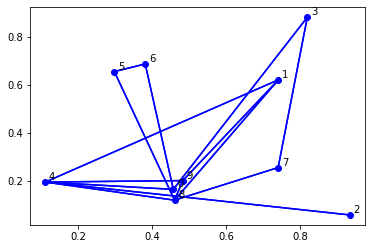

In [86]:
import numpy as np

V = np.random.rand(10, 2)

# create random adjacency list
adj_V = {}
for i in range(len(V)):
  adj = np.random.randint(0, len(V) - 1, np.random.randint(0, 5))
  adj = adj[adj != i]
  adj = list(set(adj))
  adj_V[i] = adj
  
# make adjacency list symmetric
for i in range(len(V)):
  for nbr in adj_V[i]:
    if i not in adj_V[nbr]:
      adj_V[nbr].extend([i])
      
draw(V, adj_V)

# EE Repulsion
By Lin, Yen (2012)

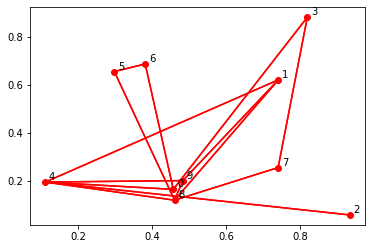

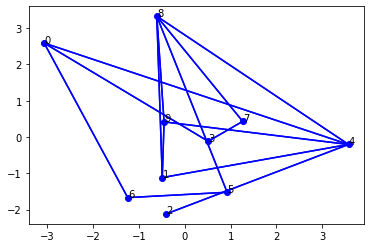

In [87]:
from scipy.spatial import ConvexHull
from math import sqrt, pi
import numpy as np
from itertools import combinations

def card(v):
  ret = np.power(v, 2)
  ret = np.sum(ret)
  ret = sqrt(ret)
  return ret

def d2(p, q):
  ret = (p[0] - q[0]) ** 2
  ret += (p[1] - q[1]) ** 2
  ret = sqrt(ret)
  return ret

def get_angle(v, w, u):
  vu = np.subtract(u, v)
  vw = np.subtract(w, v)
  ret = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
  return ret

def get_nbr_order(v, adj_v):
  '''
  return the circular order of the neighbors of v starting
  from edge vu, where u is the neighbor indexed first in adj_v.
  '''
  u = V[adj_v[0]]
  vu = np.subtract(u, v)
  angs = [0] # initialize as first in the circular order
  for i in range(1, len(adj_v)):
    w = V[adj_v[i]]
    vw = np.subtract(w, v)
    # get angle between edges vu, vw
    ang = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
    if (vw[0] * vu[1] - vu[0] * vw[1]) <= 0:
      # if vu is the right vector of the angle,
      # calculate the outer angle
      ang = (2 * pi) - ang
    angs.append(ang)
  ret = np.argsort(angs)
  ret = [adj_v[idx] for idx in ret]
  return ret

def get_rep_force(v, u, w, C3, C4, C5):
  f_e = C3 * ((np.arctan(d2(v, u) / C4)) + (np.arctan(d2(v, w) / C4)))
  ang = get_angle(v, w, u)
  f_ang = C5 * (np.cos(ang / 2)) / (np.sin(ang / 2))
  ret = f_e + f_ang
  return ret

def get_spring_force(v, u, C1, C2):
  uv = np.subtract(u, v)
  ret = card(uv)
  ret /= C2
  ret = np.log(ret)
  ret *= C1
  ret *= (uv / card(uv))
  return ret

def ee_repulsion(V, adj_V):
  W = V.copy()
  F = np.zeros((len(V), 2))
  C1 = 1 # 
  C2 = 1
  C3 = 1
  C4 = 1
  C5 = 0.001
  C6 = 1
  for i in range(len(V)):
    # calculate repulsive force
    if len(adj_V[i]) < 2:
      continue
    v = V[i]
    nbr_order = get_nbr_order(v, adj_V[i])
    for j in range(0, len(nbr_order) - 1):
      k = j + 1
      u = V[nbr_order[j]]
      w = V[nbr_order[k]]
      vu = np.subtract(u, v)
      vw = np.subtract(w, v)

      f = get_rep_force(v, u, w, C3, C4, C5)
      
      u_m = vu / card(vu) + vw / card(vw) 
      u_f = np.dot([[0, 1], [-1, 0]], u_m)

      F[nbr_order[j]] += (f * u_f)
      F[nbr_order[k]] -= (f * u_f)
      
  for i in list(adj_V):
    # calculate spring force
    for j in adj_V[i]:
      fa = get_spring_force(v, u, C1, C2)
      F[i] += fa
      F[j] -= fa
  
  for i in range(len(V)):
    W[i] = C6 * F[i]
  return W
    
W = ee_repulsion(V, adj_V)

draw(V, adj_V, color='r')
plt.clf()
draw(W, adj_V)
